<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Arya Jalali
### Student Number : 98105665
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
ADDRESS = 'efigi-1.6/png/'
from PIL import Image
import torch.optim as optim
np.random.seed(11)

c:\Users\Arya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

name   class_name  class_label
0  PGC0000212      Spirals            2
1  PGC0000218      Spirals            2
2  PGC0000243  Lenticulars            1
3  PGC0000255      Spirals            2
4  PGC0000281      Spirals            2

C:\Users\Arya\AppData\Local\Temp\ipykernel_14276\1716776932.py:26: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output_images = np.array(output_images)
C:\Users\Arya\AppData\Local\Temp\ipykernel_14276\1716776932.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_images = np.array(output_images)


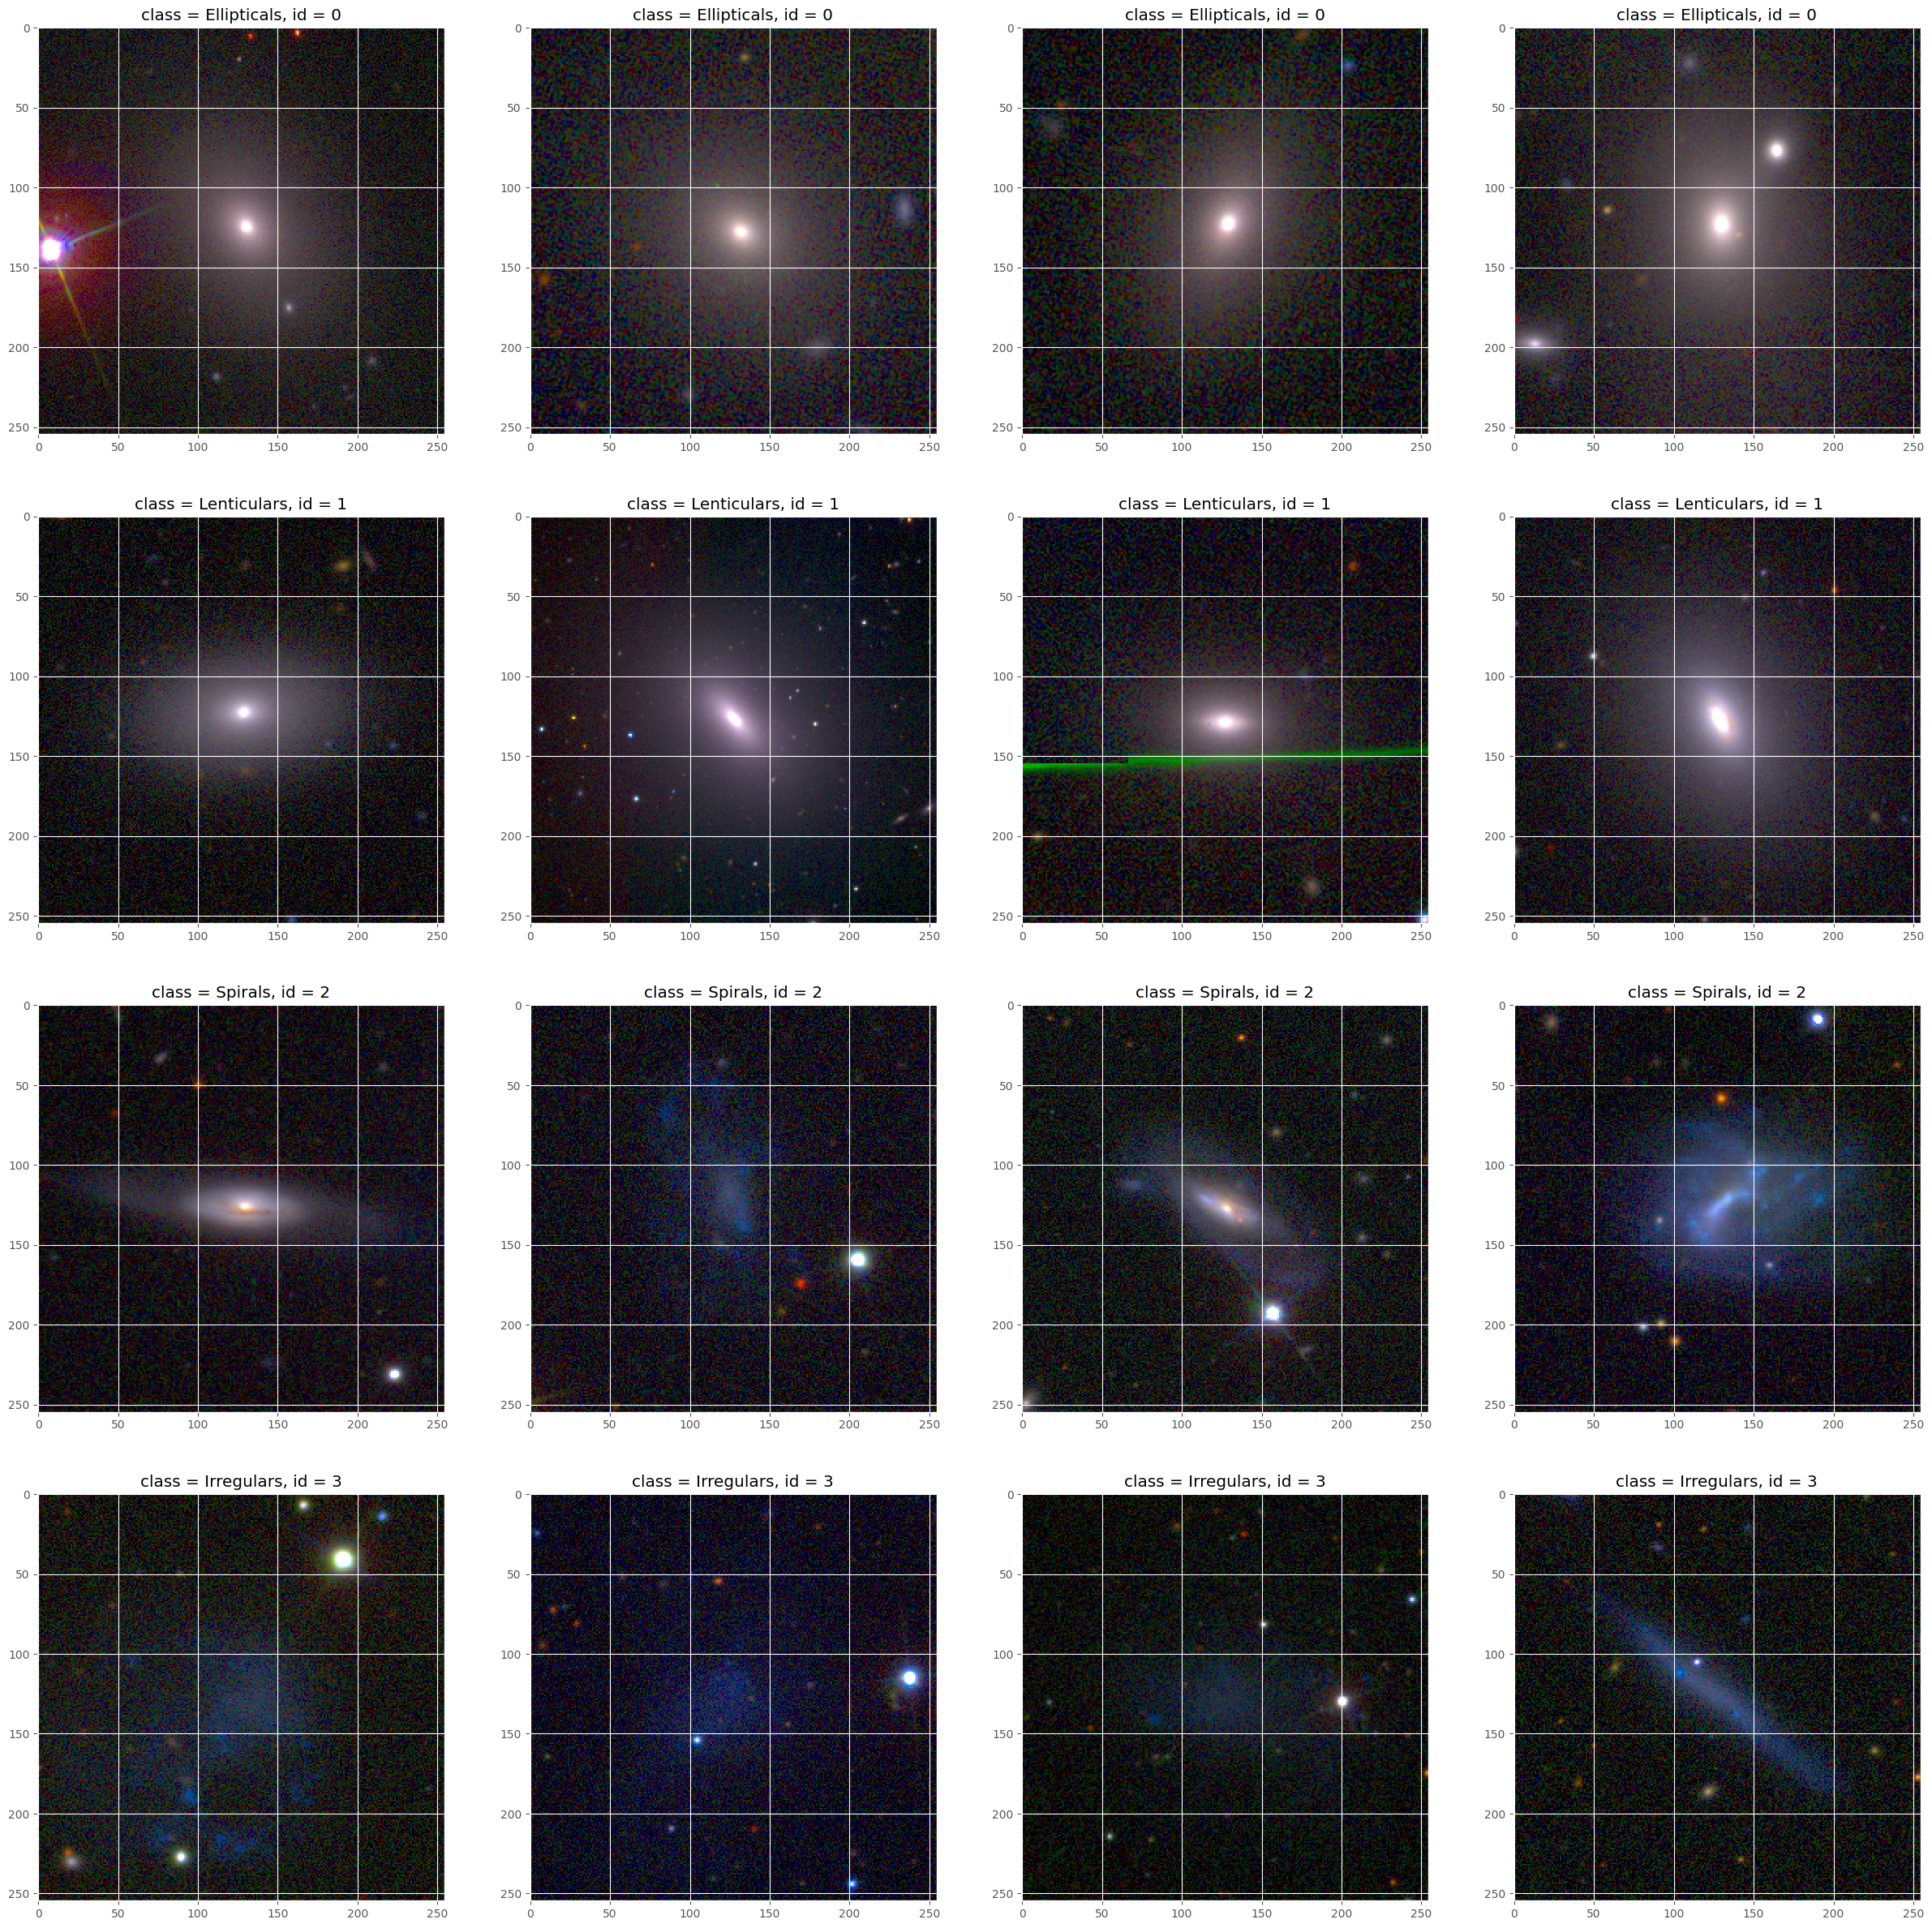

In [4]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################

SIZE = 28

def get_pictures(arr):
  pil_img = []
  for img_name in arr[:,0]:
      img = Image.open(ADDRESS + img_name + '.png')
      pil_img.append(img)
  return pil_img, arr[:,1:3]

X = df.values
output_images= []
info = []

for i in range(4):
  _class = X[(X[:,2] == i),:]
  names = _class[np.random.choice(_class.shape[0], 4, replace=False), :]
  a,b = get_pictures(names)
  output_images.append(a)
  info.append(b)

output_images = np.array(output_images)
info = np.array(info).reshape(4,4,2)


fig = plt.figure(figsize=(30, 30)) 

for i in range(16):
    sub = fig.add_subplot(4, 4, i + 1)
    sub.set_title(f'class = {info[i // 4, i % 4][0]}, id = {info[i // 4, i % 4][1]}')
    sub.imshow(output_images[i // 4,i % 4], interpolation='nearest')

# Define Dataset (20 Points)

In [5]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

from sklearn.model_selection import train_test_split

X = df.values

y, X = X[:,2], X[:,0:2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 2/10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/8)

class GalaxyDataSet(Dataset):
    def __init__(self,type ,transform = None):
        self.types = {
            'train': (X_train, y_train),
            'val': (X_val, y_val),
            'test': (X_test, y_test)
        }
        self.type = type
        self.transform = transform
        self.X, self.y = self.types[type]
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(ADDRESS + self.X[idx][0] + '.png')
        if self.transform:
            img = self.transform(img)
        return img, self.y[idx]

# Define Model (20 Points)

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.seq1 = nn.Sequential(
          nn.Flatten(),
          nn.Linear(SIZE * SIZE * 3, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.seq1(x)
        return x


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # flip
    transforms.RandomHorizontalFlip(p=0.2),
    # rotate
    transforms.RandomRotation(10), 
])

test_transforms = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

galaxy_train = GalaxyDataSet(type = 'train', transform = train_transforms)
galaxy_test = GalaxyDataSet(type = 'test', transform = test_transforms)
galaxy_val = GalaxyDataSet(type = 'val', transform = test_transforms)

training_generator = DataLoader(galaxy_train, batch_size=32,shuffle=True, num_workers=0)
test_generator = DataLoader(galaxy_test, batch_size = 32,shuffle=True, num_workers = 0)
val_generator = DataLoader(galaxy_val, batch_size = 32, shuffle=True, num_workers = 0)

# Train Model (30 Points)

In [13]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

from sklearn.utils.class_weight import compute_class_weight
import torch.backends.cudnn as cudnn

model = ClassifierModel()
model = model.to(device)

class_weights = compute_class_weight(class_weight='balanced',classes = np.unique(y_train),y =  y_train)
class_weights = torch.FloatTensor(class_weights).to(device)


cudnn.benchmark = True


loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_accuracy = -1

max_epochs = 100
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(max_epochs):
    model.train()
    # Training
    correct = 0 
    total = 0
    running_loss = 0.0
    for local_batch, local_labels in tqdm(training_generator):

        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        pred_y = model(local_batch.float())
        loss = loss_fn(pred_y, local_labels)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (pred_y.argmax(axis = 1) == local_labels).sum()
        total += local_labels.size(0)
    
    # scheduler.step()

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    train_losses.append(running_loss / len(training_generator))
    print(f'Train epoch: {epoch + 1}, loss: {running_loss / len(training_generator):.5f}, accuracy {accuracy.item():.2f}')
    
    model.eval()
    # validation phase
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for local_batch, local_labels in tqdm(val_generator):

            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            pred_y = model(local_batch.float())
            correct += (pred_y.argmax(axis = 1) == local_labels).sum()
            total += local_labels.size(0)
            running_loss += loss_fn(pred_y, local_labels).item()
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    val_losses.append(running_loss / len(val_generator))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pt')
    print(f'Validation epoch: {epoch + 1}, loss: {running_loss / len(val_generator):.5f} , accuracy {accuracy.item():.2f}')


100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


Train epoch: 1, loss: 0.65812, accuracy 74.58


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Validation epoch: 1, loss: 0.54694 , accuracy 78.25


100%|██████████| 98/98 [00:09<00:00,  9.81it/s]


Train epoch: 2, loss: 0.50107, accuracy 79.29


100%|██████████| 14/14 [00:01<00:00, 13.62it/s]


Validation epoch: 2, loss: 0.56345 , accuracy 75.78


100%|██████████| 98/98 [00:09<00:00, 10.35it/s]


Train epoch: 3, loss: 0.47575, accuracy 79.97


100%|██████████| 14/14 [00:01<00:00, 13.63it/s]


Validation epoch: 3, loss: 0.47146 , accuracy 77.80


100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


Train epoch: 4, loss: 0.43517, accuracy 82.12


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


Validation epoch: 4, loss: 0.52902 , accuracy 78.92


100%|██████████| 98/98 [00:10<00:00,  9.71it/s]


Train epoch: 5, loss: 0.43328, accuracy 82.34


100%|██████████| 14/14 [00:01<00:00, 13.05it/s]


Validation epoch: 5, loss: 0.43021 , accuracy 80.94


100%|██████████| 98/98 [00:09<00:00, 10.37it/s]


Train epoch: 6, loss: 0.40399, accuracy 83.21


100%|██████████| 14/14 [00:01<00:00, 12.90it/s]


Validation epoch: 6, loss: 0.50683 , accuracy 78.03


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]


Train epoch: 7, loss: 0.41831, accuracy 82.79


100%|██████████| 14/14 [00:01<00:00, 12.50it/s]


Validation epoch: 7, loss: 1.59396 , accuracy 39.24


100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


Train epoch: 8, loss: 0.39411, accuracy 83.78


100%|██████████| 14/14 [00:01<00:00, 11.69it/s]


Validation epoch: 8, loss: 0.46197 , accuracy 80.94


100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Train epoch: 9, loss: 0.41287, accuracy 82.28


100%|██████████| 14/14 [00:01<00:00,  9.16it/s]


Validation epoch: 9, loss: 0.45989 , accuracy 79.15


100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Train epoch: 10, loss: 0.37799, accuracy 84.68


100%|██████████| 14/14 [00:01<00:00, 13.08it/s]


Validation epoch: 10, loss: 1.16940 , accuracy 55.38


100%|██████████| 98/98 [00:10<00:00,  9.26it/s]


Train epoch: 11, loss: 0.36641, accuracy 84.26


100%|██████████| 14/14 [00:01<00:00, 13.42it/s]


Validation epoch: 11, loss: 0.54213 , accuracy 77.13


100%|██████████| 98/98 [00:11<00:00,  8.89it/s]


Train epoch: 12, loss: 0.37632, accuracy 84.07


100%|██████████| 14/14 [00:01<00:00, 13.12it/s]


Validation epoch: 12, loss: 0.55731 , accuracy 77.80


100%|██████████| 98/98 [00:12<00:00,  7.94it/s]


Train epoch: 13, loss: 0.36381, accuracy 84.65


100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


Validation epoch: 13, loss: 0.50113 , accuracy 82.29


100%|██████████| 98/98 [00:12<00:00,  7.84it/s]


Train epoch: 14, loss: 0.36096, accuracy 85.29


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


Validation epoch: 14, loss: 0.96877 , accuracy 74.89


100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


Train epoch: 15, loss: 0.36686, accuracy 84.90


100%|██████████| 14/14 [00:01<00:00, 13.16it/s]


Validation epoch: 15, loss: 0.40382 , accuracy 82.51


100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Train epoch: 16, loss: 0.34976, accuracy 84.90


100%|██████████| 14/14 [00:01<00:00, 13.46it/s]


Validation epoch: 16, loss: 0.56372 , accuracy 77.35


100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Train epoch: 17, loss: 0.35989, accuracy 84.84


100%|██████████| 14/14 [00:01<00:00, 13.15it/s]


Validation epoch: 17, loss: 0.47564 , accuracy 80.27


100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Train epoch: 18, loss: 0.34899, accuracy 85.19


100%|██████████| 14/14 [00:01<00:00, 12.79it/s]


Validation epoch: 18, loss: 0.41468 , accuracy 82.29


100%|██████████| 98/98 [00:09<00:00, 10.52it/s]


Train epoch: 19, loss: 0.33703, accuracy 85.99


100%|██████████| 14/14 [00:01<00:00, 13.63it/s]


Validation epoch: 19, loss: 0.49197 , accuracy 78.25


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]


Train epoch: 20, loss: 0.32665, accuracy 86.41


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


Validation epoch: 20, loss: 0.57657 , accuracy 79.60


100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Train epoch: 21, loss: 0.33921, accuracy 86.12


100%|██████████| 14/14 [00:01<00:00, 12.95it/s]


Validation epoch: 21, loss: 0.79563 , accuracy 68.83


100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Train epoch: 22, loss: 0.34521, accuracy 85.26


100%|██████████| 14/14 [00:01<00:00, 13.02it/s]


Validation epoch: 22, loss: 0.50215 , accuracy 79.37


100%|██████████| 98/98 [00:09<00:00,  9.90it/s]


Train epoch: 23, loss: 0.33426, accuracy 86.44


100%|██████████| 14/14 [00:01<00:00, 13.70it/s]


Validation epoch: 23, loss: 0.47226 , accuracy 82.96


100%|██████████| 98/98 [00:09<00:00, 10.02it/s]


Train epoch: 24, loss: 0.32491, accuracy 86.51


100%|██████████| 14/14 [00:01<00:00, 13.73it/s]


Validation epoch: 24, loss: 0.41892 , accuracy 81.17


100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


Train epoch: 25, loss: 0.31005, accuracy 87.66


100%|██████████| 14/14 [00:01<00:00, 13.18it/s]


Validation epoch: 25, loss: 0.55399 , accuracy 80.49


100%|██████████| 98/98 [00:09<00:00, 10.84it/s]


Train epoch: 26, loss: 0.33111, accuracy 85.80


100%|██████████| 14/14 [00:01<00:00, 12.70it/s]


Validation epoch: 26, loss: 0.67656 , accuracy 74.44


100%|██████████| 98/98 [00:09<00:00, 10.55it/s]


Train epoch: 27, loss: 0.31370, accuracy 87.12


100%|██████████| 14/14 [00:00<00:00, 14.19it/s]


Validation epoch: 27, loss: 0.43647 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.45it/s]


Train epoch: 28, loss: 0.31401, accuracy 86.31


100%|██████████| 14/14 [00:01<00:00, 13.82it/s]


Validation epoch: 28, loss: 0.75427 , accuracy 68.61


100%|██████████| 98/98 [00:09<00:00, 10.47it/s]


Train epoch: 29, loss: 0.30124, accuracy 87.40


100%|██████████| 14/14 [00:01<00:00, 13.25it/s]


Validation epoch: 29, loss: 0.38353 , accuracy 82.96


100%|██████████| 98/98 [00:09<00:00, 10.55it/s]


Train epoch: 30, loss: 0.30568, accuracy 87.05


100%|██████████| 14/14 [00:01<00:00, 13.02it/s]


Validation epoch: 30, loss: 0.42314 , accuracy 81.17


100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Train epoch: 31, loss: 0.30403, accuracy 86.96


100%|██████████| 14/14 [00:01<00:00, 10.58it/s]


Validation epoch: 31, loss: 0.39801 , accuracy 84.08


100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Train epoch: 32, loss: 0.30146, accuracy 86.86


100%|██████████| 14/14 [00:01<00:00, 13.62it/s]


Validation epoch: 32, loss: 0.61320 , accuracy 80.94


100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


Train epoch: 33, loss: 0.29676, accuracy 87.47


100%|██████████| 14/14 [00:01<00:00, 13.40it/s]


Validation epoch: 33, loss: 0.38027 , accuracy 84.08


100%|██████████| 98/98 [00:09<00:00, 10.74it/s]


Train epoch: 34, loss: 0.28866, accuracy 87.50


100%|██████████| 14/14 [00:01<00:00, 13.57it/s]


Validation epoch: 34, loss: 0.42369 , accuracy 81.84


100%|██████████| 98/98 [00:09<00:00, 10.43it/s]


Train epoch: 35, loss: 0.30159, accuracy 87.05


100%|██████████| 14/14 [00:01<00:00, 12.54it/s]


Validation epoch: 35, loss: 0.71680 , accuracy 78.70


100%|██████████| 98/98 [00:10<00:00,  9.74it/s]


Train epoch: 36, loss: 0.30154, accuracy 87.85


100%|██████████| 14/14 [00:01<00:00, 13.06it/s]


Validation epoch: 36, loss: 0.48992 , accuracy 81.61


100%|██████████| 98/98 [00:09<00:00, 10.30it/s]


Train epoch: 37, loss: 0.29369, accuracy 87.34


100%|██████████| 14/14 [00:01<00:00, 13.37it/s]


Validation epoch: 37, loss: 0.86866 , accuracy 66.59


100%|██████████| 98/98 [00:10<00:00,  9.76it/s]


Train epoch: 38, loss: 0.29964, accuracy 87.63


100%|██████████| 14/14 [00:01<00:00, 13.03it/s]


Validation epoch: 38, loss: 0.41453 , accuracy 83.63


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Train epoch: 39, loss: 0.27045, accuracy 88.33


100%|██████████| 14/14 [00:01<00:00, 12.58it/s]


Validation epoch: 39, loss: 0.48550 , accuracy 80.04


100%|██████████| 98/98 [00:09<00:00, 10.45it/s]


Train epoch: 40, loss: 0.28654, accuracy 88.33


100%|██████████| 14/14 [00:01<00:00, 13.80it/s]


Validation epoch: 40, loss: 0.45941 , accuracy 83.63


100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Train epoch: 41, loss: 0.27000, accuracy 89.10


100%|██████████| 14/14 [00:01<00:00, 13.19it/s]


Validation epoch: 41, loss: 0.42249 , accuracy 82.29


100%|██████████| 98/98 [00:09<00:00, 10.39it/s]


Train epoch: 42, loss: 0.27665, accuracy 88.69


100%|██████████| 14/14 [00:01<00:00, 13.94it/s]


Validation epoch: 42, loss: 0.47960 , accuracy 80.72


100%|██████████| 98/98 [00:09<00:00, 10.65it/s]


Train epoch: 43, loss: 0.27539, accuracy 88.46


100%|██████████| 14/14 [00:01<00:00, 12.63it/s]


Validation epoch: 43, loss: 0.51223 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.21it/s]


Train epoch: 44, loss: 0.26930, accuracy 88.46


100%|██████████| 14/14 [00:01<00:00, 13.96it/s]


Validation epoch: 44, loss: 0.43146 , accuracy 82.29


100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Train epoch: 45, loss: 0.28453, accuracy 88.24


100%|██████████| 14/14 [00:00<00:00, 14.09it/s]


Validation epoch: 45, loss: 1.15281 , accuracy 61.88


100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Train epoch: 46, loss: 0.26365, accuracy 89.10


100%|██████████| 14/14 [00:00<00:00, 14.04it/s]


Validation epoch: 46, loss: 0.43010 , accuracy 82.74


100%|██████████| 98/98 [00:09<00:00, 10.89it/s]


Train epoch: 47, loss: 0.26883, accuracy 88.78


100%|██████████| 14/14 [00:01<00:00, 13.92it/s]


Validation epoch: 47, loss: 0.46661 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.86it/s]


Train epoch: 48, loss: 0.28946, accuracy 87.98


100%|██████████| 14/14 [00:01<00:00, 12.87it/s]


Validation epoch: 48, loss: 0.53204 , accuracy 82.29


100%|██████████| 98/98 [00:09<00:00, 10.75it/s]


Train epoch: 49, loss: 0.27538, accuracy 88.46


100%|██████████| 14/14 [00:00<00:00, 14.02it/s]


Validation epoch: 49, loss: 0.70399 , accuracy 78.48


100%|██████████| 98/98 [00:09<00:00, 10.82it/s]


Train epoch: 50, loss: 0.26068, accuracy 89.26


100%|██████████| 14/14 [00:01<00:00, 13.84it/s]


Validation epoch: 50, loss: 0.44045 , accuracy 82.06


100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Train epoch: 51, loss: 0.24583, accuracy 89.68


100%|██████████| 14/14 [00:01<00:00, 13.82it/s]


Validation epoch: 51, loss: 0.46067 , accuracy 82.96


100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


Train epoch: 52, loss: 0.26566, accuracy 88.97


100%|██████████| 14/14 [00:01<00:00, 10.89it/s]


Validation epoch: 52, loss: 0.46429 , accuracy 83.18


100%|██████████| 98/98 [00:10<00:00,  9.13it/s]


Train epoch: 53, loss: 0.26127, accuracy 88.56


100%|██████████| 14/14 [00:00<00:00, 14.05it/s]


Validation epoch: 53, loss: 0.46624 , accuracy 82.74


100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


Train epoch: 54, loss: 0.25985, accuracy 89.42


100%|██████████| 14/14 [00:01<00:00, 13.30it/s]


Validation epoch: 54, loss: 0.87769 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.38it/s]


Train epoch: 55, loss: 0.26248, accuracy 90.16


100%|██████████| 14/14 [00:01<00:00, 13.70it/s]


Validation epoch: 55, loss: 0.44918 , accuracy 82.51


100%|██████████| 98/98 [00:09<00:00, 10.65it/s]


Train epoch: 56, loss: 0.24164, accuracy 90.51


100%|██████████| 14/14 [00:01<00:00, 13.42it/s]


Validation epoch: 56, loss: 0.74198 , accuracy 80.72


100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Train epoch: 57, loss: 0.25495, accuracy 89.65


100%|██████████| 14/14 [00:01<00:00, 11.19it/s]


Validation epoch: 57, loss: 0.43356 , accuracy 83.86


100%|██████████| 98/98 [00:08<00:00, 10.95it/s]


Train epoch: 58, loss: 0.24380, accuracy 90.54


100%|██████████| 14/14 [00:01<00:00, 13.98it/s]


Validation epoch: 58, loss: 0.44730 , accuracy 81.84


100%|██████████| 98/98 [00:08<00:00, 10.97it/s]


Train epoch: 59, loss: 0.23119, accuracy 90.67


100%|██████████| 14/14 [00:01<00:00, 13.36it/s]


Validation epoch: 59, loss: 1.11912 , accuracy 59.64


100%|██████████| 98/98 [00:09<00:00, 10.61it/s]


Train epoch: 60, loss: 0.25277, accuracy 89.07


100%|██████████| 14/14 [00:01<00:00, 13.88it/s]


Validation epoch: 60, loss: 0.57818 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.72it/s]


Train epoch: 61, loss: 0.23321, accuracy 90.74


100%|██████████| 14/14 [00:01<00:00, 12.32it/s]


Validation epoch: 61, loss: 0.48992 , accuracy 83.41


100%|██████████| 98/98 [00:09<00:00, 10.62it/s]


Train epoch: 62, loss: 0.23832, accuracy 90.06


100%|██████████| 14/14 [00:01<00:00, 13.41it/s]


Validation epoch: 62, loss: 0.47258 , accuracy 82.96


100%|██████████| 98/98 [00:09<00:00, 10.58it/s]


Train epoch: 63, loss: 0.23704, accuracy 90.29


100%|██████████| 14/14 [00:00<00:00, 14.41it/s]


Validation epoch: 63, loss: 0.98296 , accuracy 77.13


100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Train epoch: 64, loss: 0.24125, accuracy 89.94


100%|██████████| 14/14 [00:00<00:00, 14.02it/s]


Validation epoch: 64, loss: 0.61726 , accuracy 73.32


100%|██████████| 98/98 [00:08<00:00, 11.23it/s]


Train epoch: 65, loss: 0.24195, accuracy 90.38


100%|██████████| 14/14 [00:01<00:00, 13.41it/s]


Validation epoch: 65, loss: 0.46600 , accuracy 81.61


100%|██████████| 98/98 [00:09<00:00,  9.80it/s]


Train epoch: 66, loss: 0.22869, accuracy 90.80


100%|██████████| 14/14 [00:01<00:00, 12.22it/s]


Validation epoch: 66, loss: 0.60571 , accuracy 78.03


100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Train epoch: 67, loss: 0.23275, accuracy 89.94


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


Validation epoch: 67, loss: 0.65105 , accuracy 80.49


100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Train epoch: 68, loss: 0.21958, accuracy 90.71


100%|██████████| 14/14 [00:01<00:00, 13.13it/s]


Validation epoch: 68, loss: 0.46093 , accuracy 82.29


100%|██████████| 98/98 [00:09<00:00, 10.04it/s]


Train epoch: 69, loss: 0.23141, accuracy 90.74


100%|██████████| 14/14 [00:01<00:00, 13.19it/s]


Validation epoch: 69, loss: 0.45939 , accuracy 81.61


100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


Train epoch: 70, loss: 0.24516, accuracy 89.84


100%|██████████| 14/14 [00:01<00:00, 13.05it/s]


Validation epoch: 70, loss: 0.50408 , accuracy 80.94


100%|██████████| 98/98 [00:10<00:00,  9.27it/s]


Train epoch: 71, loss: 0.23369, accuracy 90.42


100%|██████████| 14/14 [00:01<00:00,  9.56it/s]


Validation epoch: 71, loss: 0.44077 , accuracy 82.29


100%|██████████| 98/98 [00:11<00:00,  8.59it/s]


Train epoch: 72, loss: 0.21650, accuracy 91.06


100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


Validation epoch: 72, loss: 0.57877 , accuracy 79.37


100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


Train epoch: 73, loss: 0.20821, accuracy 91.31


100%|██████████| 14/14 [00:01<00:00, 10.80it/s]


Validation epoch: 73, loss: 0.66827 , accuracy 80.72


100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Train epoch: 74, loss: 0.23317, accuracy 90.61


100%|██████████| 14/14 [00:01<00:00, 13.35it/s]


Validation epoch: 74, loss: 0.55341 , accuracy 80.94


100%|██████████| 98/98 [00:09<00:00, 10.67it/s]


Train epoch: 75, loss: 0.22769, accuracy 90.74


100%|██████████| 14/14 [00:01<00:00, 13.32it/s]


Validation epoch: 75, loss: 0.71406 , accuracy 81.39


100%|██████████| 98/98 [00:09<00:00, 10.27it/s]


Train epoch: 76, loss: 0.22444, accuracy 91.19


100%|██████████| 14/14 [00:01<00:00, 13.14it/s]


Validation epoch: 76, loss: 0.59430 , accuracy 76.91


100%|██████████| 98/98 [00:09<00:00, 10.00it/s]


Train epoch: 77, loss: 0.23095, accuracy 90.99


100%|██████████| 14/14 [00:01<00:00, 11.30it/s]


Validation epoch: 77, loss: 0.55606 , accuracy 83.86


100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


Train epoch: 78, loss: 0.21933, accuracy 91.06


100%|██████████| 14/14 [00:01<00:00, 13.60it/s]


Validation epoch: 78, loss: 0.67099 , accuracy 80.04


100%|██████████| 98/98 [00:10<00:00,  9.13it/s]


Train epoch: 79, loss: 0.22241, accuracy 90.80


100%|██████████| 14/14 [00:01<00:00, 11.64it/s]


Validation epoch: 79, loss: 0.51292 , accuracy 80.04


100%|██████████| 98/98 [00:10<00:00,  9.34it/s]


Train epoch: 80, loss: 0.21947, accuracy 91.25


100%|██████████| 14/14 [00:01<00:00, 11.87it/s]


Validation epoch: 80, loss: 0.52283 , accuracy 82.29


100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


Train epoch: 81, loss: 0.21941, accuracy 91.19


100%|██████████| 14/14 [00:01<00:00, 11.22it/s]


Validation epoch: 81, loss: 0.58010 , accuracy 79.15


100%|██████████| 98/98 [00:10<00:00,  8.97it/s]


Train epoch: 82, loss: 0.19894, accuracy 91.86


100%|██████████| 14/14 [00:01<00:00, 11.66it/s]


Validation epoch: 82, loss: 0.54353 , accuracy 82.06


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]


Train epoch: 83, loss: 0.20049, accuracy 91.44


100%|██████████| 14/14 [00:01<00:00, 13.34it/s]


Validation epoch: 83, loss: 0.73729 , accuracy 78.92


100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Train epoch: 84, loss: 0.20660, accuracy 91.89


100%|██████████| 14/14 [00:01<00:00, 13.71it/s]


Validation epoch: 84, loss: 0.52870 , accuracy 82.06


100%|██████████| 98/98 [00:10<00:00,  9.43it/s]


Train epoch: 85, loss: 0.22730, accuracy 91.47


100%|██████████| 14/14 [00:01<00:00, 10.46it/s]


Validation epoch: 85, loss: 0.58606 , accuracy 82.06


100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Train epoch: 86, loss: 0.21668, accuracy 91.41


100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


Validation epoch: 86, loss: 0.62219 , accuracy 78.92


100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Train epoch: 87, loss: 0.21304, accuracy 91.54


100%|██████████| 14/14 [00:01<00:00, 11.17it/s]


Validation epoch: 87, loss: 0.63057 , accuracy 78.92


100%|██████████| 98/98 [00:10<00:00,  9.62it/s]


Train epoch: 88, loss: 0.21971, accuracy 90.74


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


Validation epoch: 88, loss: 1.09543 , accuracy 78.03


100%|██████████| 98/98 [00:10<00:00,  9.17it/s]


Train epoch: 89, loss: 0.19397, accuracy 92.47


100%|██████████| 14/14 [00:01<00:00, 12.43it/s]


Validation epoch: 89, loss: 0.55418 , accuracy 81.61


100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Train epoch: 90, loss: 0.19015, accuracy 92.31


100%|██████████| 14/14 [00:01<00:00, 12.94it/s]


Validation epoch: 90, loss: 0.59534 , accuracy 82.96


100%|██████████| 98/98 [00:09<00:00, 10.31it/s]


Train epoch: 91, loss: 0.19803, accuracy 91.63


100%|██████████| 14/14 [00:01<00:00, 12.91it/s]


Validation epoch: 91, loss: 0.70465 , accuracy 79.37


100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


Train epoch: 92, loss: 0.19510, accuracy 92.18


100%|██████████| 14/14 [00:01<00:00, 10.90it/s]


Validation epoch: 92, loss: 0.52515 , accuracy 82.96


100%|██████████| 98/98 [00:13<00:00,  7.46it/s]


Train epoch: 93, loss: 0.20162, accuracy 91.96


100%|██████████| 14/14 [00:01<00:00,  9.34it/s]


Validation epoch: 93, loss: 0.47474 , accuracy 81.84


100%|██████████| 98/98 [00:13<00:00,  7.52it/s]


Train epoch: 94, loss: 0.18831, accuracy 92.21


100%|██████████| 14/14 [00:01<00:00,  8.91it/s]


Validation epoch: 94, loss: 0.58384 , accuracy 80.49


100%|██████████| 98/98 [00:12<00:00,  7.93it/s]


Train epoch: 95, loss: 0.19793, accuracy 91.89


100%|██████████| 14/14 [00:01<00:00, 13.54it/s]


Validation epoch: 95, loss: 0.87617 , accuracy 79.82


100%|██████████| 98/98 [00:09<00:00, 10.50it/s]


Train epoch: 96, loss: 0.18919, accuracy 92.40


100%|██████████| 14/14 [00:01<00:00, 13.08it/s]


Validation epoch: 96, loss: 0.83664 , accuracy 73.54


100%|██████████| 98/98 [00:11<00:00,  8.59it/s]


Train epoch: 97, loss: 0.20026, accuracy 92.47


100%|██████████| 14/14 [00:01<00:00, 12.62it/s]


Validation epoch: 97, loss: 0.54097 , accuracy 81.84


100%|██████████| 98/98 [00:09<00:00, 10.44it/s]


Train epoch: 98, loss: 0.21054, accuracy 92.05


100%|██████████| 14/14 [00:01<00:00, 12.75it/s]


Validation epoch: 98, loss: 0.72307 , accuracy 75.56


100%|██████████| 98/98 [00:09<00:00, 10.45it/s]


Train epoch: 99, loss: 0.19651, accuracy 91.60


100%|██████████| 14/14 [00:01<00:00, 13.32it/s]


Validation epoch: 99, loss: 0.40777 , accuracy 84.08


100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Train epoch: 100, loss: 0.19712, accuracy 91.70


100%|██████████| 14/14 [00:01<00:00, 12.72it/s]

Validation epoch: 100, loss: 0.49972 , accuracy 80.27


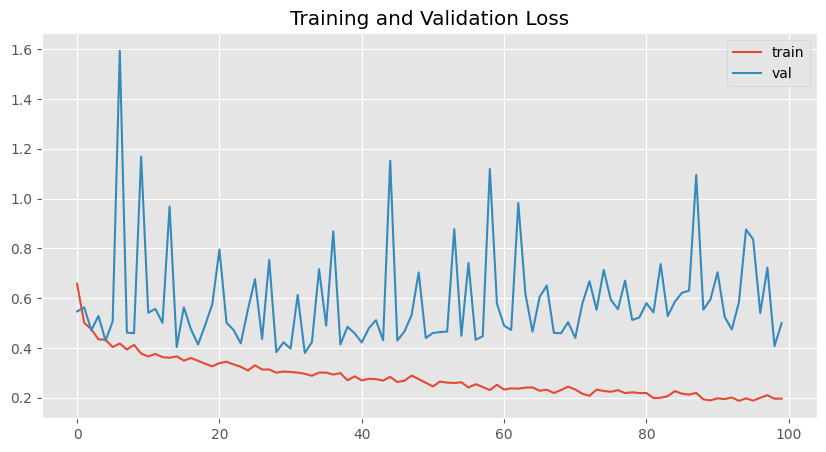

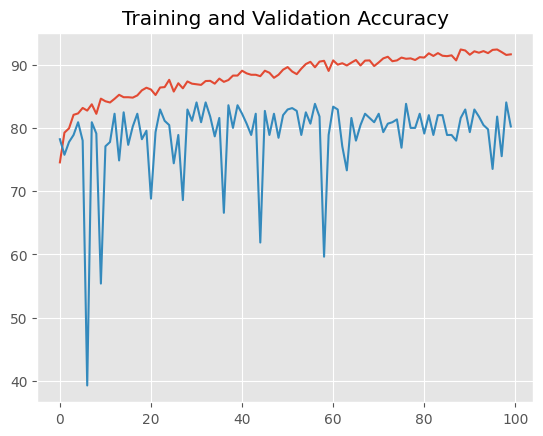

In [14]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

model.load_state_dict(torch.load('best_model.pt'))

# change figsize
plt.figure(figsize=(10, 5))

#accuracies to cpu if not on it
train_accuracies = [i.cpu().numpy() for i in train_accuracies]
val_accuracies = [i.cpu().numpy() for i in val_accuracies]


# plot val and train loss in the same figure
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Training and Validation Loss')
plt.legend(['train', 'val'])
plt.show()

# plot val and train accuracy in the same figure
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Training and Validation Accuracy')
plt.show()

# Test Model (20)

100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Test Accuracy of the model: 85.43
Test: F1-score: 0.85


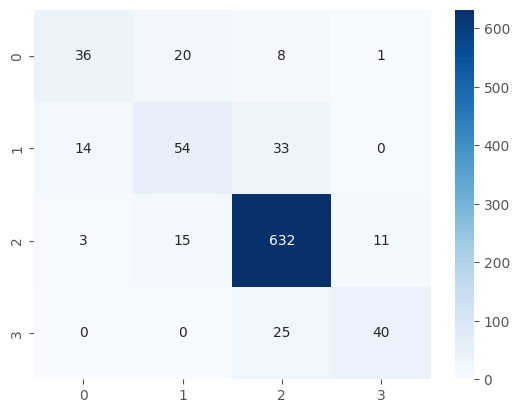

In [15]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

from sklearn.metrics import f1_score


num_correct, total  = 0, 0

model.eval()


y_pred = []
y_true = []

with torch.no_grad():
    for data, labels in tqdm(test_generator):

        data, labels = data.to(device=device), labels.to(device=device)

        predictions = model(data.float()).argmax(axis = 1)
        y_pred.append(predictions)
        y_true.append(labels)
        num_correct += (predictions == labels).sum()
        total += labels.size(0)

    print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")


# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = torch.cat(y_pred).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()

print(f'Test: F1-score: {f1_score(y_true, y_pred, average="micro"):.2f}')

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
